In [1]:
# https://github.com/thierrygrimm/CpGIslandHMM/blob/master/Jupyter%20Notebooks/CpG%20islands%20Hidden%20Markov%20Model.ipynb
from matplotlib.patches import Rectangle
import re
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Vitervi

# Forward Algorithm

In [2]:

def forward(sequence, initmat, a, e):
    states = [0, 1]
    seqlen = len(sequence)
    #print("Logitud Secuencia {}".format(seqlen))
    f = [[0]*seqlen, [0]*seqlen]
    ptr = [[0]*seqlen]
    nucleotide = {"A": 0, "T": 1, "G": 2, "C": 3}
    for k in states:
        f[k][0] = initmat[k]*e[k][nucleotide[sequence[0]]]
    for i in range(1, seqlen):
        for k in states:
            # Sum of both last previous probs*transitions for each state
            f[k][i] = f[states[0]][i-1]*a[states[0]][k]
            # Remaining state
            for l in states[1:]:
                f[k][i] += f[l][i-1]*a[l][k]
            f[k][i] = f[k][i]*e[k][nucleotide[sequence[i]]]
    return f

# Backward Algorithm

In [3]:
def backward(sequence, initmat, a, e):

    states = [0, 1]
    seqlen = len(sequence)
    print("Logitud Secuencia {}".format(seqlen))
    b = [[0]*seqlen, [0]*seqlen]
    nucleotide = {"A": 0, "T": 1, "C": 2, "G": 3}
    for k in states:
        b[k][-1] = 1
    for i in np.arange(seqlen-2, -1, -1):
        # -1 for index shift, -1 for second last column
        for k in states:
            b[k][i] = b[states[0]][i+1] * a[k][states[0]] * \
                e[states[0]][nucleotide[sequence[i+1]]]
            # Remaining state
            for l in states[1:]:
                b[k][i] += b[l][i+1]*a[k][l]*e[l][nucleotide[sequence[i+1]]]
            b[k][i] = b[k][i]
    start = 0
    for k in states:
        start += b[k][0]*e[k][nucleotide[sequence[0]]]*initmat[k]
    return b

In [4]:
def operation(f, b, sequence):
    probs = (np.multiply(f, b) / np.sum(f, axis=0)[-1])
    valueprint = ["-"]*len(sequence)
    state=np.argmax(probs,axis=0)
    for i in range(len(sequence)):
        if state[i]==1:
            valueprint[i]="+"
    return [valueprint, probs]

In [5]:
transitions = np.zeros((2, 2))  # +- / +-
emissions = np.zeros((4, 2))  # +- / ACTG
initiations = np.zeros((1, 2))  # +- / Probability

# Matrices

In [6]:
Iteration = 4
test_sequencex = []
test_keyx = []
# Gen 1
test_keyx.append("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
test_sequencex.append("TCGAGCTGGAGTATCCAAAGCACCGAAAAGATGGTCGGACGACTCCGTATTTGGGGATAGAGCATATTTTATCTTTGACAAGGAACCGGGAAAACTGTCAATTCAGAATACGCAAGCATCCGACTCCGGAACTTATAGATGTCGCGTGGACTTCCTGAAAGCGCAGACCATAAACAGCCG")
# No Gen 1
test_keyx.append("++++++------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
test_sequencex.append("AAGATGGTAAGTCAAAACTTGTATCTTCAATGTTCAGAATGCTTAAAAAATAGTATCCAAAAATGAGCATGATTAAATTATTAATGAATGTAACTGTAAAACTTTTTTTGATTTCTTTAGCAAAAATTTTTGATTGCGGTTTGGTTGATTTAACATATCTTTTTTAGCTAACCGGCTAAG")
# Gen 2
test_keyx.append("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++---------------------------------------------")
test_sequencex.append("AAATACACACACACACACCGAAACACGGACACACTCGTACACTCACACACTCGCAACGTAACGCACACCAACGCGTATTCGCACCCACACACAAGTGAAGTCGGCTCTGCAAACGCACAAGTGCGGTGTATCTGTGTGAGTAGCCATAGAAGAGGTGTTTGGCATTGTGCTCAGGATACA")
# No Gen 2
test_keyx.append("------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
test_sequencex.append("GGATTTGGTGGCCAAGTGCTTAATAAAACCATCATAAACCCCAAAAACCATCAAAAGTGATAAATGCAAATATACCCCTAATGAATGAATACAAGCAATCGCAAAAGTGTGTGGCCTCAAGGAGCCAAGCCAAGTATAATCCCAACCATTGGCCAAGTGGTAATGCATCGTCGGATTAAA")
# Gen 3
test_keyx.append("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
test_sequencex.append("GATTCAGTTGAAGCTCAGCCGTCGGACTGTTTTGAACGTGGTTTTGCAGGGATGCTGACGCTCGCTGCGGCAGCCATCGAATTAGCGAAGTTATCGGGTCTCGTCCTGCACACACACTCACACCCACCCACAAACGCTGAGAATCGGGTGCGCTGTTTCGCGAATAAATATAATTCTCGT")
# No Gen 3
test_keyx.append("++++++++++++++++++++++++++++++++++++++----------------------------------------------------------------------------------------------------------------------------------------------")
test_sequencex.append("GATTATCCTGCGTGGGACAAATTTAAATTGCTCGCCAGGTAAGTTGGACGAGCTCACTTTTTGCTCTTTAAGAGTGACTTTTTGCCCAAAAGTTTACTAACTAAAGTTGAAATTGCCAACCGCCCTCGCAGTTGCTGCAGTTAGAGAAAAACGTCTCAGATAAATTAAGCTTCTGGTAAC")
# Gen 4
test_keyx.append("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
test_sequencex.append("TCAGTTTCGTATTCGTGTCGGAACGTGGCGCTACGGTCTTCTGCTCAACGATACGCGAAAATCCAATCCGCTGGAGGAGCAAAACGCGGCGCGTGGAACCCACAAAACAAGCAAGCAAGCCAAACGAAAAAGGAAGCTAAAGCACAACTCATTCGGTCGAGTGTGCCTGTGTGAGAGTGT")
# No Gen 4
test_keyx.append("+++++++++++-------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
test_sequencex.append("GTCCTCGAAAAGTGCGTATGGAACTGCAAGTTAATTAAGTATTTGACTCTGCATATGACAAATCCCGGTTTAAGCGAAAAGCGACTTTAATTCGCAATTCGAAACGGGTTTCGTTAATGTTTATCGTCTTGTTCTCGATTAAATCGGCTGTCGCGGGCGTAATATATTCATGGAATCCTT")
# Seccion 1
test_keyx.append("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
test_sequencex.append("TAACTTCTAACCAATTAAACGTACCAATCTGCAATAGTGGCCAATAGCGTACTAGATATGAAAGTCATTAAGTCGATGTAATCAACAACTAACCAGTGCTATTCCAATAAATATACAACATGGAGTTACTGCTGCTGTTTATGCTAGCACTTCAACTTATAGAATCCAGCATCGGAAGTAAAGATGGTAAGTCAAAACTTGTATCTTCAATGTTCAGAATGCTTAAAAAATAGTATCCAAAAATGAGCATGATTAAATTATTAATGAATGTAACTGTAAAACTTTTTTTGATTTCTTTAGCAAAAATTTTTGATTGCGGTTTGGTTGATTTAACATATCTTTTTTAGCTAACCGGCTAAG")
# Seccion 2
test_keyx.append("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
test_sequencex.append("AAATACACACACACACACCGAAACACGGACACACTCGTACACTCACACACTCGCAACGTAACGCACACCAACGCGTATTCGCACCCACACACAAGTGAAGTCGGCTCTGCAAACGCACAAGTGCGGTGTATCTGTGTGAGTAGCCATAGAAGAGGTGTTTGGCATTGTGCTCAGGATACAGGATTTGGTGGCCAAGTGCTTAATAAAACCATCATAAACCCCAAAAACCATCAAAAGTGATAAATGCAAATATACCCCTAATGAATGAATACAAGCAATCGCAAAAGTGTGTGGCCTCAAGGAGCCAAGCCAAGTATAATCCCAACCATTGGCCAAGTGGTAATGCATCGTCGGATTAAA")
# Seccion 3
test_keyx.append("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
test_sequencex.append("TGCGTGACAAAAGTCAAGCAACAGTAGCAACAATAATATTAGCAACAAAAGCAGCAACAGAAGCAACAGCAGCAGCAGCACCACCACCACCAAACACAAATAGCAACAACTGCAATAAAGGATTATCCTGCGTGGGACAAATTTAAATTGCTCGCCAGGTAAGTTGGACGAGCTCACTTTTTGCTCTTTAAGAGTGACTTTTTGCCCAAAAGTTTACTAACTAAAGTTGAAATTGCCAACCGCCCTCGCAGTTGCTGCAGTTAGAGAAAAACGTCTCAGATAAATTAAGCTTCTGGTAACTTTCTAATTAATTAAGTGAGTTTGCCATGTTACATAATTCTTTTTACGTTCTTTTTTCAA")
# Seccion 4
test_keyx.append("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
test_sequencex.append("AGTGCTCCAGATTTGCCAACCATTTGTTGGTGCACTTATCGCGATTGCCGCACGGATTGCTTCACCTGCAACCTGCAACCTGCCACCTGCACCTGCCACCAACATTCTGCACCCTGCCGCGTCCTCGAAAAGTGCGTATGGAACTGCAAGTTAATTAAGTATTTGACTCTGCATATGACAAATCCCGGTTTAAGCGAAAAGCGACTTTAATTCGCAATTCGAAACGGGTTTCGTTAATGTTTATCGTCTTGTTCTCGATTAAATCGGCTGTCGCGGGCGTAATATATTCATGGAATCCTTCTGCGTGCTGCACTTAATAGCATTTAACTGGCAATTAATTGCCTTGAGCTCAGCCACCCA")

if Iteration == 0:
    sequences = pd.read_csv('DataSet/Sequences.txt', header=None)[0]
    keys = pd.read_csv('DataSet/Keys.txt', header=None)[0]
elif Iteration == 1:
    sequences = pd.read_csv('DataSet/Sequences1.txt', header=None)[0]
    keys = pd.read_csv('DataSet/Annotations1.txt', header=None)[0]
elif Iteration == 2:
    test_sequence2=""
    sequences = pd.read_csv('DataSet/Sequences2.txt', header=None)[0]
    keys = pd.read_csv('DataSet/Annotations2.txt', header=None)[0]
elif Iteration == 3:
    test_sequence2=""
    sequences = pd.read_csv('DataSet/Sequences3.txt', header=None)[0]
    keys = pd.read_csv('DataSet/Annotations3.txt', header=None)[0]
elif Iteration == 4:
    test_sequence2=""
    sequences = pd.read_csv('DataSet/Sequences4.txt', header=None)[0]
    keys = pd.read_csv('DataSet/Annotations4.txt', header=None)[0]


keys_ohe = [x.replace('+', "1").replace('-', "0") for x in keys]  # binary
count1 = 0
count2 = 0
for p in keys_ohe:
    str_0 = p.count('0')
    str_1 = p.count('1')
    count1 = count1 + str_0 
    count2 = count2 + str_1
        
totals = [count1, count2] # - +
print('Total: 0 / 1')
print(totals)
print('\n')

# Transition Array
for i in range(2):
    for x in range(2):
        query = str(i)+str(x)
        transitions[i][x] = np.sum(
            [len(re.findall('(?=%s)' % query, keys_ohe[n])) for n in range(len(keys))])/(totals[i])

print('Transitions: -+ / -+')
print(transitions)
print('\n')
non_cpgs = [[m.start() for m in re.finditer('0', n)] for n in keys_ohe]
cpgs = [[m.start() for m in re.finditer('1', n)] for n in keys_ohe]

cp_nuc = [[sequences[r][i] for i in cpgs[r]] for r in range(len(sequences))]
non_cp_nuc = [[sequences[r][i] for i in non_cpgs[r]]
              for r in range(len(sequences))]
states = [non_cp_nuc, cp_nuc]
nucs = ['A', 'T', 'G', 'C']
totals2 = [np.sum([len(x) for x in non_cp_nuc]),
           np.sum([len(x) for x in cp_nuc])]

# Emisssion Array
for nuc in range(len(nucs)):
    for state in range(len(states)):
        emissions[nuc][state] = np.sum(
            [n.count(nucs[nuc]) for n in states[state]])/totals2[state]

print('Emissions: ATGC/-+')
print(emissions)
print('\n')

# Initiation Array (occurence in sequence)
pos = np.sum([int(n[0]) for n in keys_ohe])
initiations = [pos/(len(keys)-1), 1-pos/(len(keys)-1)]

print('Initiations: -+/Probabilites')
print(initiations)


Total: 0 / 1
[96200, 20054]


Transitions: -+ / -+
[[9.82889813e-01 4.26195426e-04]
 [2.04447990e-03 9.81300489e-01]]


Emissions: ATGC/-+
[[0.29580042 0.27770021]
 [0.28614345 0.24852897]
 [0.21003119 0.23002892]
 [0.20802495 0.2437419 ]]


Initiations: -+/Probabilites
[0.17234262125902994, 0.82765737874097]


In [7]:
states = [0,1]
start_p = [initiations[1], initiations[0]]
trans_p = [[transitions[0][0], transitions[0][1]], [transitions[1][0], transitions[1][1]]]
emit_p = [[emissions[0][0], emissions[1][0], emissions[2][0], emissions[3][0]],
          [emissions[0][1], emissions[1][1], emissions[2][1], emissions[3][1]]]

print('Transitions: -+ / -+')
print(trans_p)
print(initiations[1] + initiations[0])
print('\n')
print('Emissions: ATGC/-+')
print(emit_p)
print(emissions[0][0] + emissions[1][0] + emissions[2][0] + emissions[3][0])
print(emissions[0][1] + emissions[1][1] + emissions[2][1] + emissions[3][1])
print('\n')
print('Initiations: -+/Probabilites')
print(start_p)
print(initiations[1] + initiations[0])
print('\n')

Transitions: -+ / -+
[[0.9828898128898129, 0.0004261954261954262], [0.002044479904258502, 0.9813004886805625]]
1.0


Emissions: ATGC/-+
[[0.29580041580041583, 0.28614345114345113, 0.21003118503118504, 0.20802494802494803], [0.2777002094345268, 0.24852897177620425, 0.23002892191084073, 0.24374189687842823]]
1.0
1.0


Initiations: -+/Probabilites
[0.82765737874097, 0.17234262125902994]
1.0




In [8]:
fx = []
bx = []
probx = []
responsex = []
###############
for i in range(0,12):
    fx.append(forward(test_sequencex[i], start_p, trans_p, emit_p))
    bx.append(backward(test_sequencex[i], start_p, trans_p, emit_p))
    responsex.append(operation(fx[i], bx[i], test_sequencex[i]))
    probx.append(responsex[i][1])
    

Logitud Secuencia 180
Logitud Secuencia 180
Logitud Secuencia 180
Logitud Secuencia 180
Logitud Secuencia 180
Logitud Secuencia 180
Logitud Secuencia 180
Logitud Secuencia 180
Logitud Secuencia 360
Logitud Secuencia 360
Logitud Secuencia 360
Logitud Secuencia 360


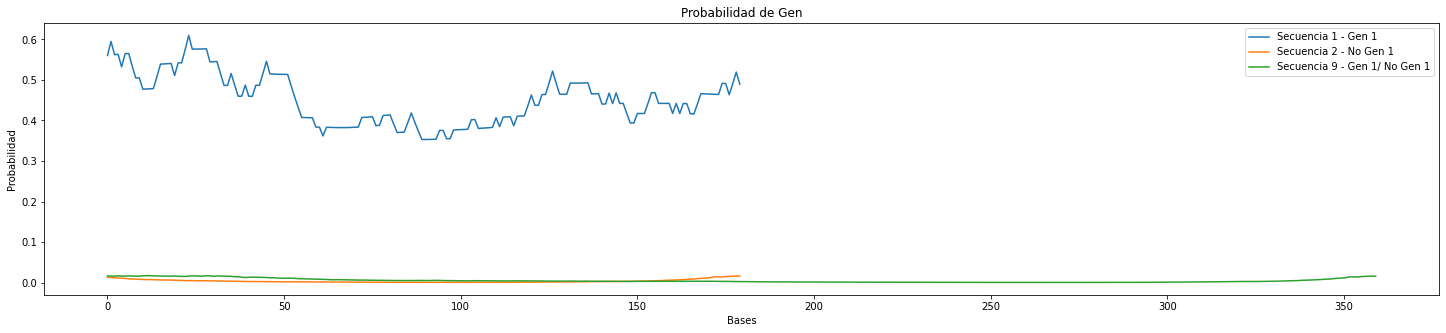

In [9]:
plt.figure(figsize=(25, 5))
if Iteration == 1:
    plt.plot(probx[6][1],  label='Secuencia 7 - Gen 4')
    plt.plot(probx[7][1],  label='Secuencia 8 - No Gen 4')
    plt.plot(probx[11][1],  label='Secuencia 12 - Gen 4/ No Gen 4')
elif Iteration == 2:
    plt.plot(probx[4][1],  label='Secuencia 5 - Gen 3')
    plt.plot(probx[5][1],  label='Secuencia 6 - No Gen 3')
    plt.plot(probx[10][1],  label='Secuencia 11 - Gen 3/ No Gen 3')
elif Iteration == 3:
    plt.plot(probx[2][1],  label='Secuencia 3 - Gen 2')
    plt.plot(probx[3][1],  label='Secuencia 4 - No Gen 2')
    plt.plot(probx[9][1],  label='Secuencia 10 - Gen 2/ No Gen 2')
elif Iteration == 4:
    plt.plot(probx[0][1],  label='Secuencia 1 - Gen 1')
    plt.plot(probx[1][1],  label='Secuencia 2 - No Gen 1')
    plt.plot(probx[8][1],  label='Secuencia 9 - Gen 1/ No Gen 1')
  
plt.title('Probabilidad de Gen')
plt.xlabel('Bases')
plt.ylabel('Probabilidad')
plt.legend(loc='best')
plt.show()

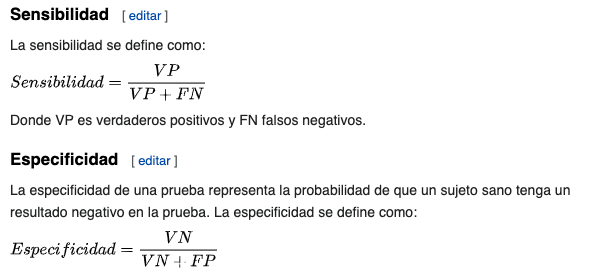 

In [54]:
# 1- Gen, 2- No gen, 3- Compleja
option = 4
if Iteration == 1:
    if option == 1:
        proby = probx[6][1]
        test_keyy = test_keyx[6]
    elif option == 2:
        proby = probx[7][1]
        test_keyy = test_keyx[7]
    elif option == 3:
        proby = probx[11][1]
        test_keyy = test_keyx[11]
    elif option == 4:
        proby = np.concatenate((probx[6][1], probx[7][1]))
        proby = np.concatenate((proby, probx[11][1])) 
        test_keyy = test_keyx[6] + test_keyx[7] + test_keyx[11]
        
elif Iteration == 2:
    if option == 1:
        proby = probx[4][1]
        test_keyy = test_keyx[4]
    elif option == 2:
        proby = probx[5][1]
        test_keyy = test_keyx[5]
    elif option == 3:
        proby = probx[10][1]
        test_keyy = test_keyx[10]
    elif option == 4:
        proby = np.concatenate((probx[4][1], probx[5][1]))
        proby = np.concatenate((proby, probx[10][1])) 
        test_keyy = test_keyx[4] + test_keyx[5] + test_keyx[11]
        
elif Iteration == 3:
    if option == 1:
        proby = probx[2][1]
        test_keyy = test_keyx[2]
    elif option == 2:
        proby = probx[3][1]
        test_keyy = test_keyx[3]
    elif option == 3:
        proby = probx[9][1]
        test_keyy = test_keyx[9]
    elif option == 4:
        proby = np.concatenate((probx[2][1], probx[3][1]))
        proby = np.concatenate((proby, probx[9][1])) 
        test_keyy = test_keyx[2] + test_keyx[3] + test_keyx[9]
        
elif Iteration == 4:
    if option == 1:
        proby = probx[0][1]
        test_keyy = test_keyx[0]
    elif option == 2:
        proby = probx[1][1]
        test_keyy = test_keyx[1]
    elif option == 3:
        proby = probx[8][1]
        test_keyy = test_keyx[8]
    elif option == 4:
        proby = np.concatenate((probx[0][1], probx[1][1]))
        proby = np.concatenate((proby, probx[8][1])) 
        test_keyy = test_keyx[0] + test_keyx[1] + test_keyx[8]

Se = []
Es = []
for prob in np.arange(0.2, 0.8, 0.05):
    VP = 0
    VN = 0
    FN = 0
    FP = 0
    for x in range(0, len(proby)):
        if proby[x] > prob:
            if test_keyy[x] == "+":
                VP = VP + 1
            else:
                FP = FP + 1
        else:
            if test_keyy[x] == "-":
                VN = VN + 1
            else:
                FN = FN + 1
    try:
        Se.append(VP/(VP + FN))
    except:
        Se.append(0)
    try:
        Es.append(1 - (VN/(VN + FP)))
    except:
        Es.append(0)

print(Se)
print(Es)



[0.4838709677419355, 0.4838709677419355, 0.4838709677419355, 0.4838709677419355, 0.3629032258064516, 0.23655913978494625, 0.10752688172043011, 0.03494623655913978, 0.002688172043010753, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


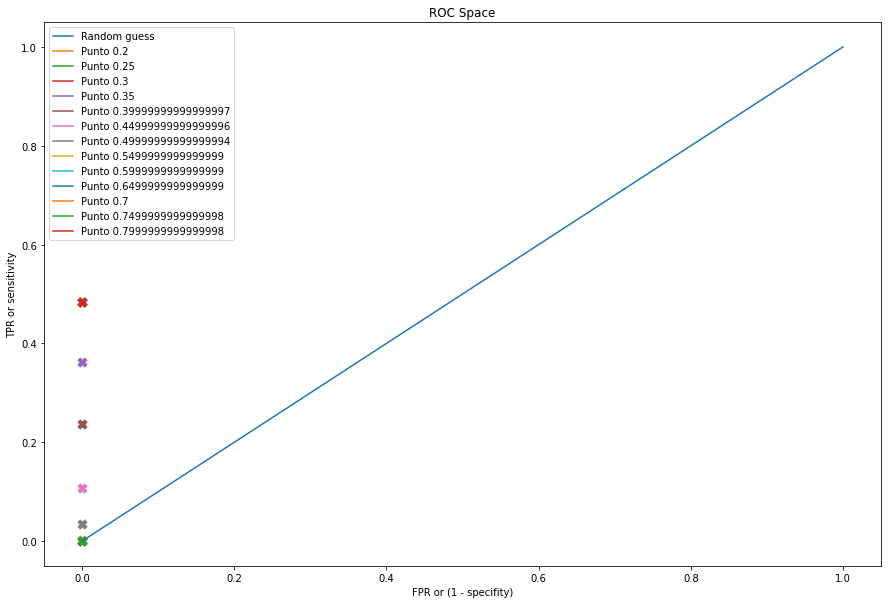

In [55]:
plt.figure(figsize=(15, 10))
counti = 0
plt.plot([0, 1], [0, 1], label='Random guess')
for prob in np.arange(0.2, 0.8, 0.05):
    x = Es[counti]
    y = Se[counti]
    z = np.sqrt(x**2 + y**2)
    plt.plot(x, y, label='Punto {}'.format(prob))
    plt.scatter(x, y, s=80, marker="X")
    counti = counti + 1
plt.title('ROC Space')
plt.xlabel('FPR or (1 - specifity)')
plt.ylabel('TPR or sensitivity')
plt.legend(loc='best')
plt.show()

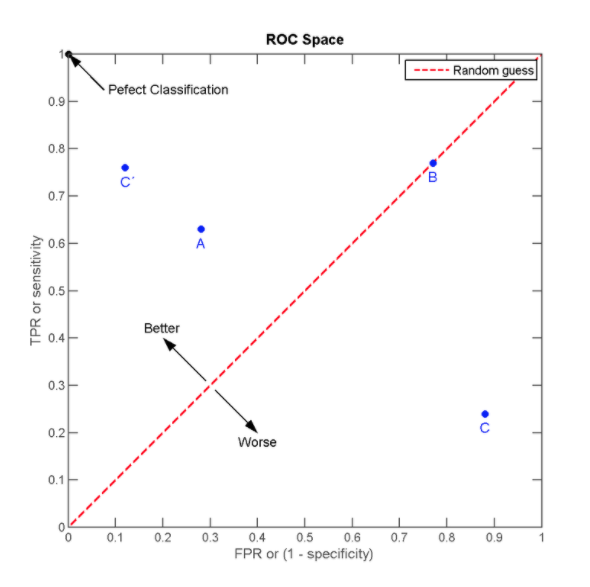

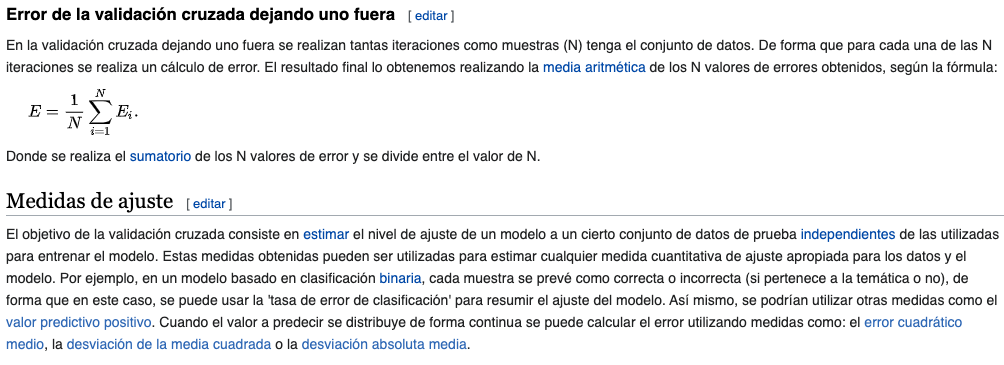